# Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

myparams = {
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}',
    'font.family': 'Djvu Serif',
    'font.size': 16,
    'axes.grid': True,
    'grid.alpha': 0.1,
    'lines.linewidth': 2
}
plt.rcParams.update(myparams)

%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

In [2]:
from utils import (
    save_object,
    load_object
)

# Regression

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
datasets_regression = load_object('dumps/datasets_regression_new.pkl')

Transform

- Forward
$$ y = \dfrac{x - \min{x}}{\max{\left(x - \min{x} \right)}} $$

- Backward
$$ \hat{x} = \min{x} + \max{\left({x} - \min{x} \right)} \hat{y} $$

In [5]:
class MeansDataset(torch.utils.data.Dataset):
    """Dataset with means of loss function on different datasets from UCI."""
    def __init__(self, lookback=5, idx=None, datasets=datasets_regression):
        super(MeansDataset, self).__init__()
        self.features = torch.tensor(np.array([datasets[name]['sample_sizes'] for name in datasets.keys()]), dtype=torch.float32)
        self.targets = torch.tensor(np.array([datasets[name]['mean'] for name in datasets.keys()]), dtype=torch.float32)
        self.features = self.transform(self.features, features=True)
        self.targets = self.transform(self.targets, features=False)
        self.X, self.y = self.create_dataset(lookback=lookback, idx=idx)

    def __getitem__(self, index):
        return (self.X[index], self.y[index])

    def __len__(self):
        return len(self.X)
    
    def create_dataset(self, lookback=5, idx=None):
        """
        Transform a time series into a prediction dataset
        
        Args:
            ts: A numpy array of time series, first dimension is the time steps
            lookback: Size of window for prediction
        """    
        X, y = [], []
        
        if idx is not None:
            sample_sizes = self.features[idx]
            means = self.targets[idx]
            for i in range(len(sample_sizes) - lookback):
                feature = sample_sizes[i:i+lookback]
                target = means[i+1:i+1+lookback]
                X.append(feature)
                y.append(target)
        else:
            for sample_sizes, means in zip(self.features, self.targets):
                for i in range(len(sample_sizes) - lookback):
                    feature = sample_sizes[i:i+lookback]
                    target = means[i+1:i+1+lookback]
                    X.append(feature)
                    y.append(target)
        
        return torch.stack(X), torch.stack(y)
    
    def transform(self, x, features=True, forward=True, idx=None):
        if forward and idx is not None:
            raise NotImplementedError()
        if forward:
            if features:
                self.features_min = x.min(axis=1).values.view(-1, 1).repeat(1, self.features.shape[1])
                self.features_max = (x - self.features_min).max(axis=1).values.view(-1, 1).repeat(1, self.features.shape[1])
                min_ = self.features_min
                max_ = self.features_max
            else:
                self.targets_min = x.min(axis=1).values.view(-1, 1).repeat(1, self.features.shape[1])
                self.targets_max = (x - self.targets_min).max(axis=1).values.view(-1, 1).repeat(1, self.features.shape[1])
                min_ = self.targets_min
                max_ = self.targets_max
            return (x - min_) / max_
        else:
            if features:
                min_ = self.features_min
                max_ = self.features_max
            else:
                min_ = self.targets_min
                max_ = self.targets_max
            if idx is None:
                return min_ + max_ * x
            else:
                return min_[idx] + max_[idx] * x

In [6]:
class LSTMForecaster(nn.Module):
    def __init__(self, hidden_size=64, num_layers=1):
        super(LSTMForecaster, self).__init__()
        self.lstm = nn.LSTM(input_size=1, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        x, _ = self.lstm(x.unsqueeze(dim=-1))
        x = self.linear(x)
        return x.squeeze(dim=-1)

In [7]:
n_epochs = 1000
lookback = 10
hidden_size = 128

dataset = MeansDataset(lookback=lookback)
model = LSTMForecaster(hidden_size=hidden_size)
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()
dataloader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=4)

for epoch in tqdm(range(n_epochs)):
    model.train()
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 1000/1000 [00:52<00:00, 19.15it/s]


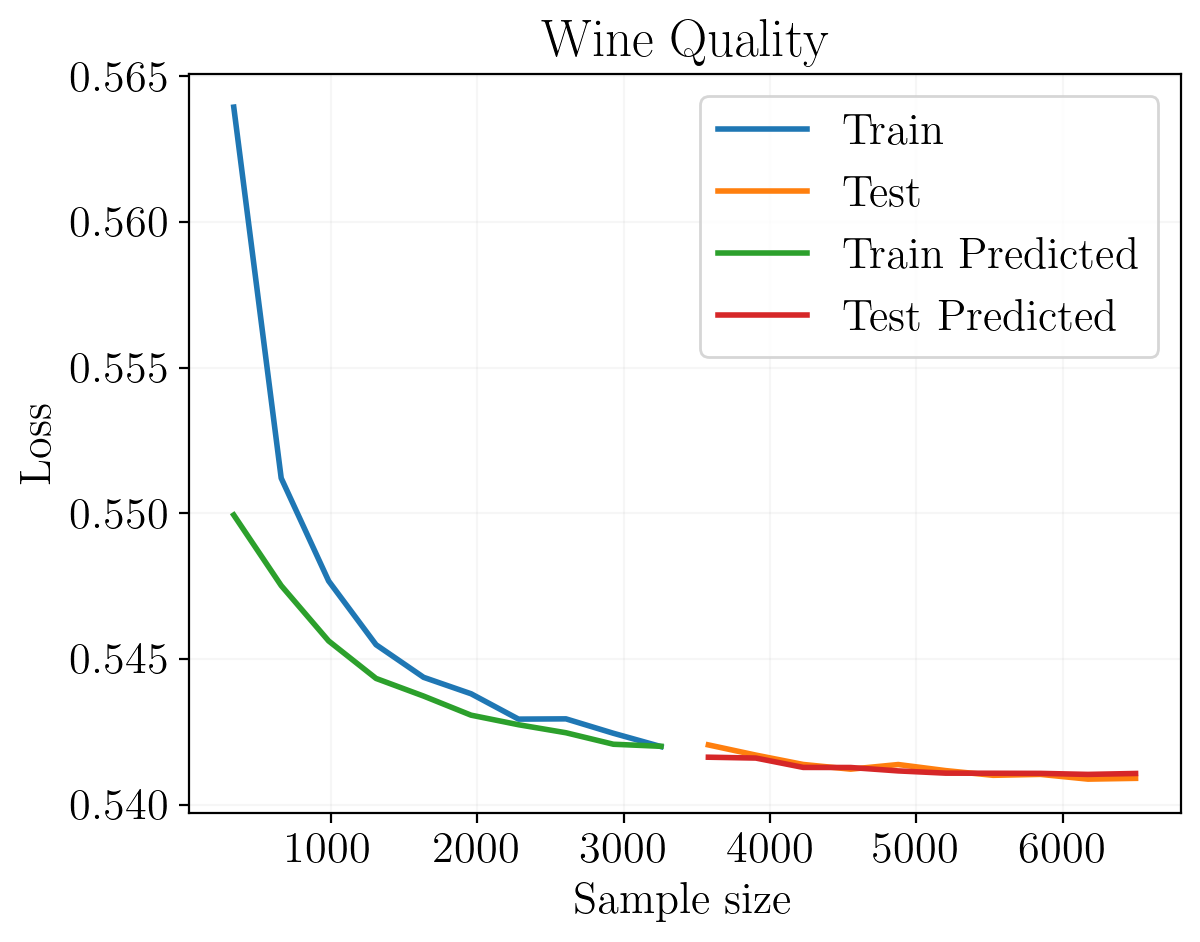

In [8]:
idx = 6 # index of dataset
n_epochs = 50

dataset = MeansDataset(lookback=lookback, idx=idx)
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()
dataloader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=4)

for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
with torch.no_grad():
    
    train_size = int(0.5 * len(dataset.features[idx]))

    samples = dataset.transform(dataset.features[idx], features=True, forward=False, idx=idx)
    means = dataset.transform(dataset.targets[idx], features=False, forward=False, idx=idx)

    train_samples = samples[:train_size]
    train_means = means[:train_size]

    test_samples = samples[train_size:]
    test_means = means[train_size:]
    
    predicted = dataset.transform(model(dataset.features[idx]), features=False, forward=False, idx=idx)
    
    plt.plot(train_samples, train_means, label='Train')
    plt.plot(test_samples, test_means, label='Test')
    plt.plot(train_samples, predicted[:train_size], label='Train Predicted')
    plt.plot(test_samples, predicted[train_size:], label='Test Predicted')
    plt.title(list(datasets_regression.keys())[idx])
    plt.xlabel('Sample size')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()